In [ ]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from src.util import testData
import src.model.reserve_market_functionality as rmf
import src.model.power_market_functionality as pmf

# Change the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#8cb369', '#38574d', '#5c5c5c', '#efd657', '#bc4b51'])

In [2]:
df = testData().loc["2019-03-12":"2019-03-13"]

# Create Network

In [3]:
components = pypsa.components.components.copy()

component_attrs = dict({k: v.copy() for k, v in pypsa.components.component_attrs.items()})
rmf.add_reserve_to_component_attrs(component_attrs)
rmf.add_reserve_market_to_component_attrs(components, component_attrs)
pmf.add_power_market_to_component_attrs(component_attrs)

In [4]:
def createGeneratorAndBESSNetwork(n):
    n.add("Bus","bus1")
    n.add("Bus","bus2")
    n.add("Bus","busb")
    n.add("Generator","gen1",bus="bus1",p_nom=100, marginal_cost=10, reserve_pos_max=100, reserve_neg_max=100)

    eta=0.9797
    n.add("Link","eleccharge", bus0 = "bus1", bus1 = "busb", p_nom = 6, efficiency = eta)
    n.add("Link","elecdischarge", bus0 = "busb", bus1 = "bus1", p_nom = 6, efficiency = eta)
    n.add("StorageUnit","bat", bus="busb", state_of_charge_initial=10,p_nom=20,standing_loss = 0,p_min_pu=-1,reserve_pos_max=20, reserve_neg_max=20)

    n.add("Generator","da",bus="bus2",marginal_cost=df["da_EUR_MWh"],is_market=True, include_bids=True, p_min_pu=-1,p_nom=np.inf)
    n.add("aFRR_Market","aFRR",marginal_cost_pos=df["aFRR_pos_EUR_MW"],marginal_cost_neg=df["aFRR_neg_EUR_MW"],include_bids=True)

    n.add("Link","link1",bus0="bus1",bus1="bus2",p_nom=1000)

In [5]:
snapshots = df.index
n = pypsa.Network(snapshots=snapshots,override_components=components,override_component_attrs=component_attrs)
createGeneratorAndBESSNetwork(n)

In [6]:
def extra_functionality(n: pypsa.Network, sn):
    rmf.add_reserve_market_to_model(n)
    pmf.add_power_market_to_model(n)

# Run Optimization

In [7]:
n.optimize(extra_functionality=extra_functionality)

Index(['bus1', 'bus2', 'busb'], dtype='object', name='Bus')
Index(['eleccharge', 'elecdischarge', 'link1'], dtype='object', name='Link')
Index(['bus1', 'bus2', 'busb'], dtype='object', name='Bus')
Index(['eleccharge', 'elecdischarge', 'link1'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.09s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2256 primals, 1800 duals
Objective: -1.65e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, aFRR-bid_capacity_constraint_pos, aFRR-bid_capacity_co

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e-02, 8e+01]
  Bound  [2e+01, 1e+02]
  RHS    [6e+00, 1e+03]
Presolving model
622 rows, 576 cols, 1726 nonzeros  0s
508 rows, 462 cols, 1791 nonzeros  0s
481 rows, 410 cols, 1701 nonzeros  0s
Presolve : Reductions: rows 481(-1319); columns 410(-1846); elements 1701(-2330)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.5782495061e-09 Ph1: 283(282859); Du: 0(3.21306e-11) 0s
        315    -1.6492080577e+05 Pr: 0(0); Du: 0(7.10543e-15) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-f_2rd6yx
Model status        : Optimal
Simplex   iterations: 315
Objective value     : -1.6492080577e+05
Relative P-D gap    :  1.7647155142e-16
HiGHS run time      :          0.01
Writing the solution to /tmp/linopy-solve-rmcs

('ok', 'optimal')

# Plot Results
## Power of Generators and Storage Units

Text(0, 0.5, 'Power [MW]')

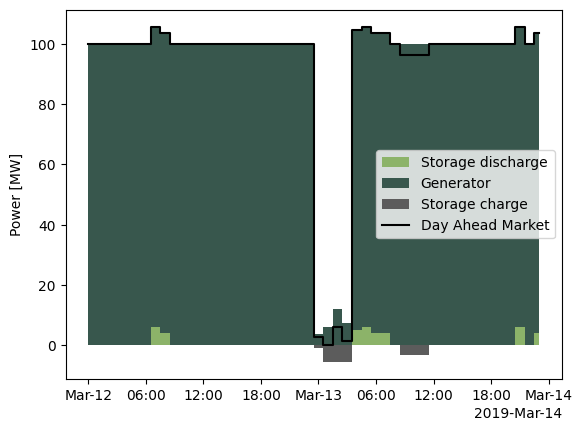

In [8]:
from matplotlib.dates import ConciseDateFormatter, AutoDateLocator

p_gen = n.generators_t.p["gen1"]
p_stu = n.storage_units_t.p["bat"]
p_market = -n.generators_t.p["da"]

# split the storage unit power into charging and discharging
p_stu_charge = p_stu.clip(upper=0)
p_stu_discharge = p_stu.clip(lower=0)

p_stacked = pd.concat([p_stu_discharge,p_gen], axis=1, keys=["Storage discharge","Generator"])
fig, ax = plt.subplots()
ax.stackplot(snapshots, p_stacked.T, labels=p_stacked.columns, step="mid")
ax.stackplot(snapshots, p_stu_charge.T, labels=["Storage charge"], step="mid")
ax.step(snapshots, p_market, label="Day Ahead Market", color="black", where="mid")

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))

ax.legend()
ax.set_ylabel("Power [MW]")

## Reserve Power (aFRR)

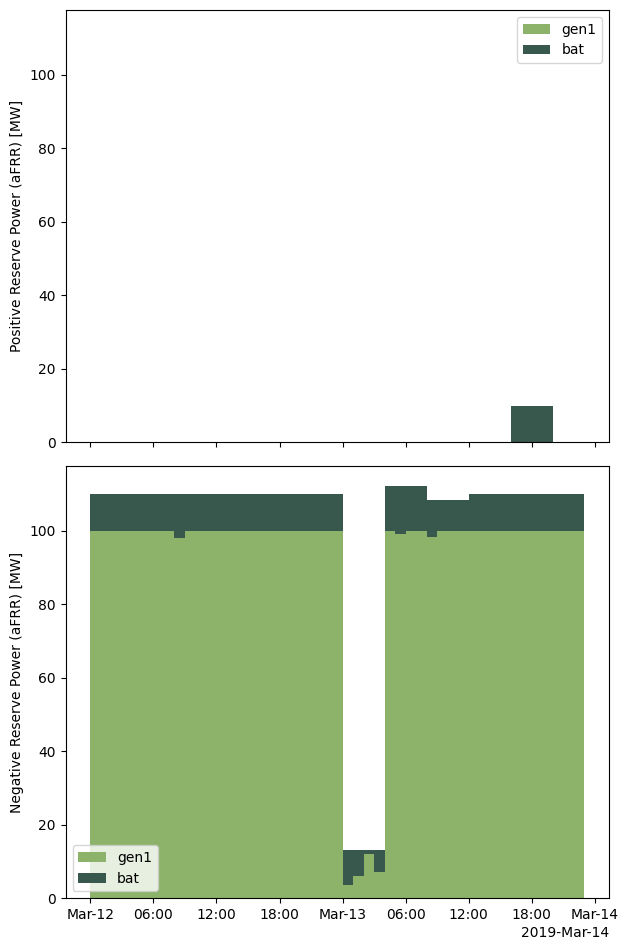

In [9]:
# index of Generators that are no power market
gen_idx = n.generators.index[~n.generators.is_market]
reserve_pos_gen = n.generators_t.reserve_pos[gen_idx]
reserve_neg_gen = n.generators_t.reserve_neg[gen_idx]
reserve_pos_stu = n.storage_units_t.reserve_pos
reserve_neg_stu = n.storage_units_t.reserve_neg

# concat the reserve power of generators and storage units
reserve_pos = pd.concat([reserve_pos_gen, reserve_pos_stu], axis=1)
reserve_neg = pd.concat([reserve_neg_gen, reserve_neg_stu], axis=1)

fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(6.4, 9.6))
axs[0].stackplot(snapshots, reserve_pos.T, labels=reserve_pos.columns, step="post")
axs[1].stackplot(snapshots, reserve_neg.T, labels=reserve_neg.columns, step="post")

for ax in axs:
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
    ax.legend()

axs[0].set_ylabel("Positive Reserve Power (aFRR) [MW]")
axs[1].set_ylabel("Negative Reserve Power (aFRR) [MW]")

fig.tight_layout()

## Market Bids

Text(0, 0.5, 'Negative aFRR Price (aFRR) [EUR/MW]')

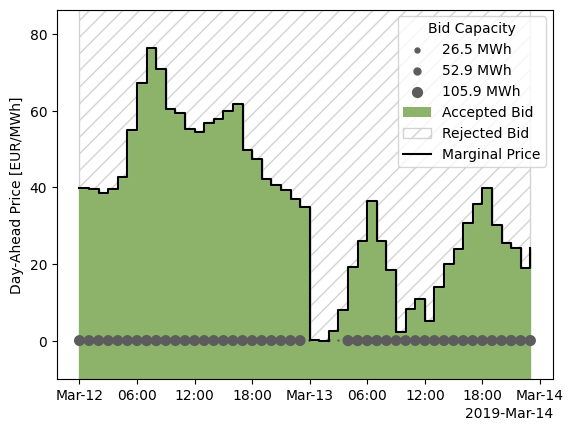

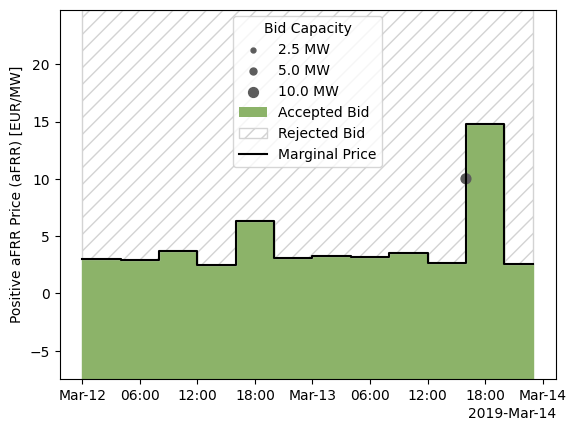

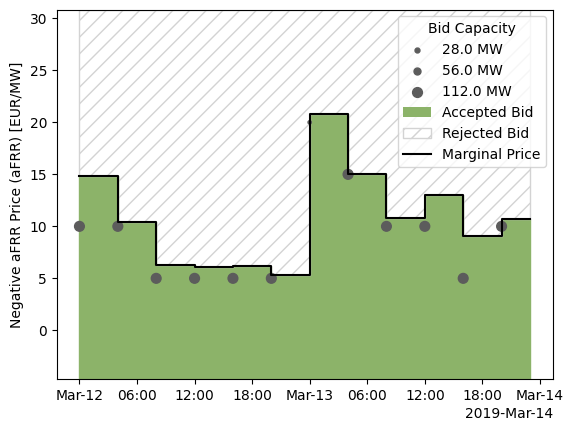

In [10]:
def plotBids(bids, marginal_price, bid_unit="MW"):
    fig, ax = plt.subplots()
    lim = marginal_price.min()-10, marginal_price.max()+10
    ax.set_ylim(lim)

    ax.fill_between(snapshots, lim[0], marginal_price, color='C0', step="post")
    ax.fill_between(snapshots, marginal_price, lim[1], color='none', step="post", hatch="//", edgecolor='lightgray')
    ax.step(snapshots, marginal_price, color='black', where="post")

    price_levels = bids.columns
    for price_level in price_levels:
        x = bids.index
        y = price_level*np.ones(x.shape)
        s = bids[price_level]/bids.max().max()*50
        ax.scatter(x, y, s=s, color='C2')    

    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))

    # add legend for marker size. Legend for 1.0, 0.5 and 0.25 times the maximum bid capacity
    handles, labels = ax.get_legend_handles_labels()
    max_bid = bids.max().max()
    for size in [0.25, 0.5, 1.0]:
        handles.append(ax.scatter([], [], s=size*50, color='C2'))
        labels.append(f'{size*max_bid:.1f} {bid_unit}')
    # add legend for accepted and rejected bids
    handles.append(Patch(facecolor='C0'))
    labels.append("Accepted Bid")
    handles.append(Patch(facecolor='none', edgecolor='lightgray', hatch="//"))
    labels.append("Rejected Bid")
    # add legend for marginal price
    handles.append(plt.Line2D([0], [0], color='black'))
    labels.append("Marginal Price")

    ax.legend(handles, labels, title="Bid Capacity")

    return ax

ax = plotBids(pmf.get_da_bids(n), df["da_EUR_MWh"], bid_unit="MWh")
ax.set_ylabel("Day-Ahead Price [EUR/MWh]")

ax = plotBids(rmf.get_aFRR_bids(n)["pos"], df["aFRR_pos_EUR_MW"])
ax.set_ylabel("Positive aFRR Price (aFRR) [EUR/MW]")

ax = plotBids(rmf.get_aFRR_bids(n)["neg"], df["aFRR_neg_EUR_MW"])
ax.set_ylabel("Negative aFRR Price (aFRR) [EUR/MW]")

## Comparison Power Transfer to Day Ahead Market and Market Price

Text(0, 0.5, 'Day-Ahead Price [EUR/MWh]')

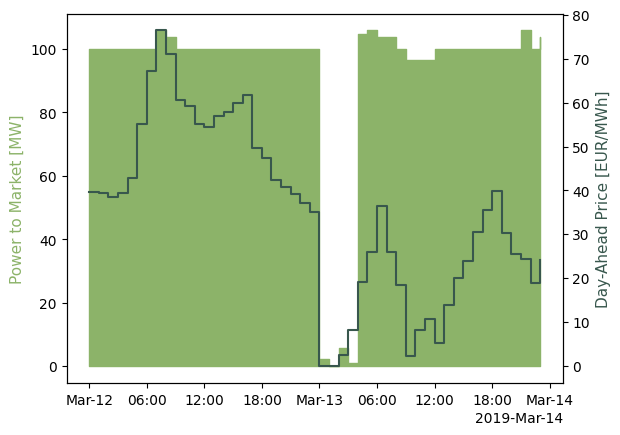

In [11]:
marginal_price = n.generators_t.marginal_cost["da"]
p_market = -n.generators_t.p["da"]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.fill_between(snapshots, p_market, color='C5', step="post")
ax2.step(snapshots, marginal_price, color='C1', where="post")
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
ax.set_ylabel("Power to Market [MW]", color='C5', fontsize=11)
ax2.set_ylabel("Day-Ahead Price [EUR/MWh]", color='C1', fontsize=11)

## State of Charge of the Storage

(0.0, 20.0)

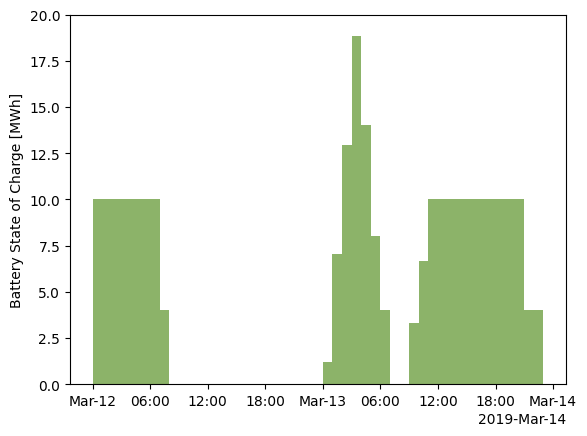

In [12]:
soc = n.storage_units_t.state_of_charge["bat"]
fig, ax = plt.subplots()
ax.fill_between(snapshots, soc, step="post")
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(ConciseDateFormatter(AutoDateLocator()))
ax.set_ylabel("Battery State of Charge [MWh]")
# Set y-axis limits from empty to full soc
max_soc = n.storage_units.at["bat", "p_nom"]
ax.set_ylim(0, max_soc)